# Convolutional Neural Network (CNN) for image recognition of the Cifar100 Dataset, implemented on Tensorflow

In the following, a CNN will be implemented for the classification of the Cifar100 dataset, the goal is to implement a networks capable enought to recognize images with more than 60% accuracy and, by using the heat maps of some layers, evaluate the patterns that the CNN is looking for.

## <a name="Head"></a> Table of contents
1. [Imports of tools and Cifar10 datasets](#A)
    1. [Building the training and testing sets](#B)
    2. [Visualization of some data points inside the training set](#C)

2. [Data preprocessing](#D)
    1. [Data normalization](#E)
    2. [Data Augmentation](#F)

3. [Training of the CNN](#G)
    1. [Ploting Function for visualization of the training process](#H)
    2. [Hyperparameters of the training process](#I)
    3. [Model definition](#J)
    4. [Model Training process](#K)
4. [Testing of the CNN](#L)
    1. [Predictions of the CNN](#LA)
    2. [Filters of the CNN](#LB)
5. [Conclusions](#M)


## Imports of tools and Cifar10 datasets: <a name="A"></a>
[[back to TOC]](#Head)

In [1]:
# Tensorflow instances

from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, Dropout, BatchNormalization, MaxPooling2D, Softmax
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers

# Drive setup

import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('gdrive/MyDrive/Colab Notebooks/models')

# Import Models

from model import model as m

# Data analysis Tools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import randint
import itertools
import time

# Cifar10 Dataset

import tensorflow.keras.datasets.cifar100 as cifar100

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Building the training and testing sets: <a name="B"></a>
[[back to TOC]](#Head)

In [50]:
# Download dataset of CIFAR-100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Check the shape of the array
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Number of samples in dataset
print(f"Train: {x_train.shape[0]}")
print(f"Test: {x_test.shape[0]}")

# Data format
print(type(x_train))
print(type(y_train))


x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Train: 50000
Test: 10000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Visualization of some data points inside the training set: <a name="C"></a>
[[back to TOC]](#Head)

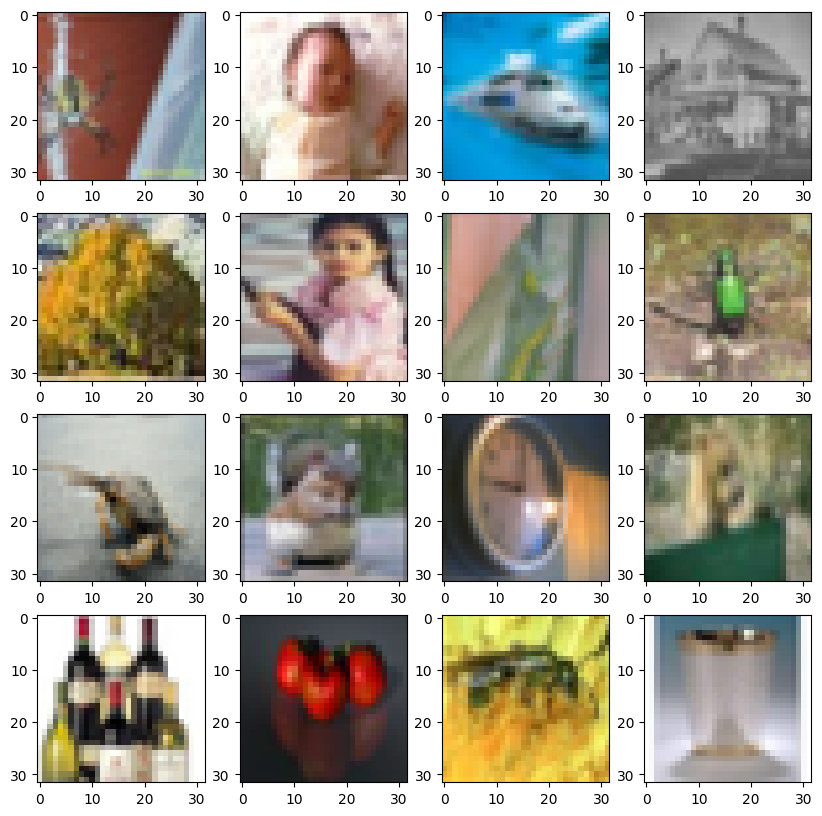

In [4]:
# Show randomly 16 images in the CIFAR-100
plt.figure(figsize=(10, 10))
for i in range (16):
  rand_num = np.random.randint(0, 50000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(x_train[rand_num])


## Data preprocessing: <a name="D"></a>
[[back to TOC]](#Head)

### Data normalization: <a name="E"></a>

In [5]:
# Import libraries for preprocessing images
from tensorflow.keras.utils import to_categorical

# Normalize images
train_images = x_train.astype('float32')/255
test_images = x_test.astype('float32')/255

# Transform labels to one hot encoding
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

### Data Augmentation: <a name="F"></a>
To avoid overfitting and to increase the number of data within the training set it is desirable to increase the number of data based on the rotation over the original set. This will lead the CNN to look for deeper paterns and to avoid oversimplistic behaviour.

In [6]:
# Data Augmentation
# Adding data augmentation for creating more images
# Divide train and validation set
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration for creating new images
train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
)

X_train, X_validation, y_train, y_validation = train_test_split(train_images, train_labels, test_size=0.2, random_state=93)
train_datagen.fit(X_train)


## Training of the CNN: <a name="G"></a>
[[back to TOC]](#Head)

Firstly, a ploting function and a set of hyperparameters will be defined in order to prepare for the training.

#### Ploting Function for visualization of the training process: <a name="H"></a>

In [8]:
# Plot function for visualisation training process
import matplotlib.pyplot as plt

def training_plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

#### Hyperparameters of the training process: <a name="I"></a>

> Indented block



In [3]:
batch_size = 32
num_classes = 100
epochs = 350

### Model definition: <a name="J"></a>
[[back to TOC]](#Head)
Secondly, one simple model with enough width and depth will be defined in order to classify the dataset.

In [4]:
# Model
# Build CNN model
model = m(input_shape=(32,32,3),num_classes=num_classes)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 128)       0

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

### Model Training process: <a name="K"></a>
[[back to TOC]](#Head)


In [26]:
# Training model.
training_start = time.time()
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=64),
          steps_per_epoch=100,
          epochs=150,
          validation_data=(X_validation, y_validation),
          verbose=1)
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/150
100/100 [==============================] - 24s 245ms/step - loss: 0.3157 - acc: 0.9044 - val_loss: 2.6362 - val_acc: 0.6125
Epoch 2/150
100/100 [==============================] - 20s 205ms/step - loss: 0.3042 - acc: 0.9045 - val_loss: 2.3876 - val_acc: 0.6136
Epoch 3/150
100/100 [==============================] - 24s 244ms/step - loss: 0.3004 - acc: 0.9131 - val_loss: 2.5667 - val_acc: 0.6116
Epoch 4/150
100/100 [==============================] - 20s 203ms/step - loss: 0.3050 - acc: 0.9077 - val_loss: 2.5618 - val_acc: 0.5988
Epoch 5/150
100/100 [==============================] - 24s 241ms/step - loss: 0.2788 - acc: 0.9153 - val_loss: 2.5946 - val_acc: 0.6034
Epoch 6/150
100/100 [==============================] - 24s 243ms/step - loss: 0.3040 - acc: 0.9133 - val_loss: 2.5954 - val_acc: 0.6046
Epoch 7/150
100/100 [==============================] - 24s 243ms/step - loss: 0.2785 - acc: 0.9153 - val_loss: 2.5817 - val_acc: 0.6003
Epoch 8/150
100/100 [===========================

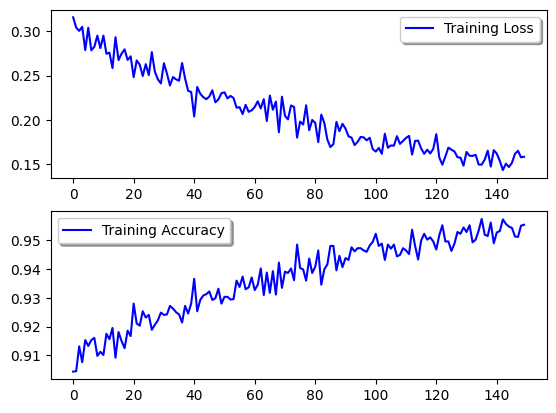

In [27]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [28]:
test_loss, test_acc = model.evaluate(X_validation, y_validation)
model.save('/content/gdrive/MyDrive/Colab Notebooks/cifar100_model.keras', save_format='h5')

313/313 [==============================] - 7s 23ms/step - loss: 2.9287 - acc: 0.6271


## Testing of the CNN: <a name="L"></a>
[[back to TOC]](#Head)

The following section will show the performance of each network in the test set, as well as the feature maps and some of the channels in the first layer of each network.

In [31]:
# Another layes is added in order get an output beter suited for probability predictions

probability_model = Sequential([model, Softmax()])
predictions = probability_model.predict(test_images)

313/313 [==============================] - 7s 22ms/step


In [44]:
classes = np.array(['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly',
                    'camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','cra','crocodile','cup',
                    'dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','keyboard','lamp','lawn_mower',
                    'leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid',
                    'otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray',
                    'road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar',
                    'sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe'
                    ,'whale','willow_tree','wolf','woman',"worm"])

def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)

  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                100*np.max(predictions_array),
                                classes[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = np.argmax(true_label[i])
  plt.grid(False)
  plt.xticks(range(num_classes))
  plt.yticks([])
  thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Predictions of the CNN: <a name="LA"></a>


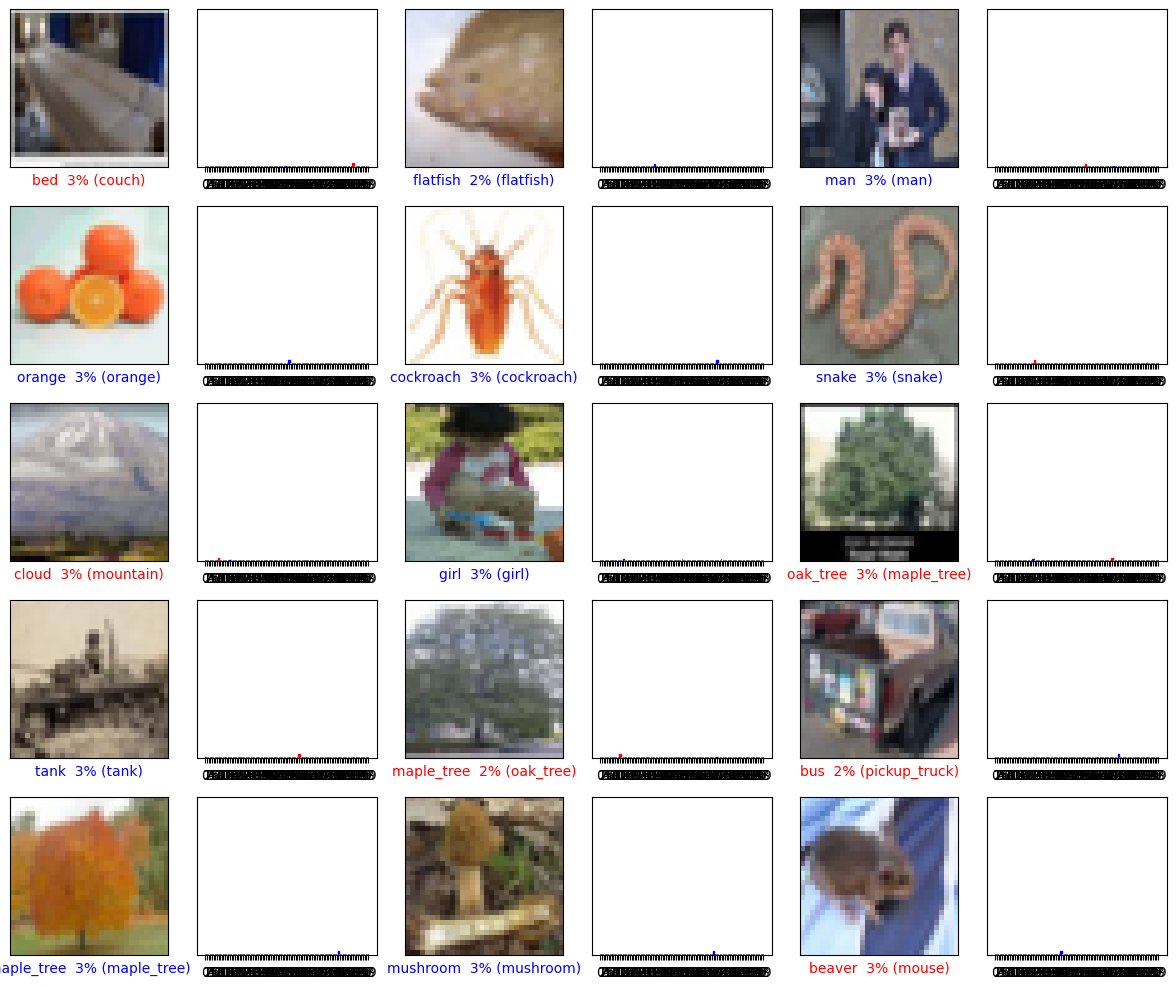

In [46]:
# 15 images are plotted to get a rough idea of how the network is performing in terms of singular examples

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  j = np.random.randint(0, 10000)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(j, predictions[j], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Filters of the CNN: <a name="LB"></a>


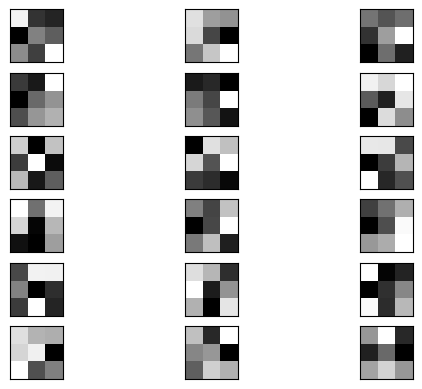

In [48]:
# retrieve weights from the second hidden layer
[filters, biases] = model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

1/1 [==============================] - 0s 71ms/step


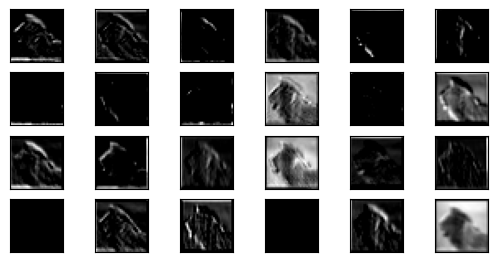

1/1 [==============================] - 0s 20ms/step


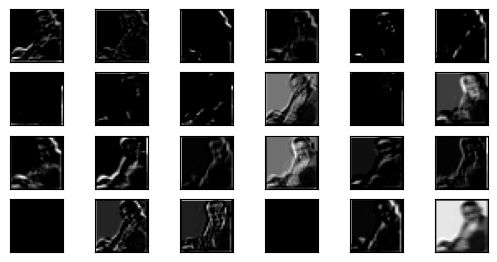

1/1 [==============================] - 0s 19ms/step


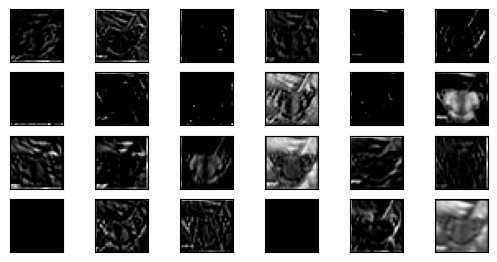

1/1 [==============================] - 0s 36ms/step


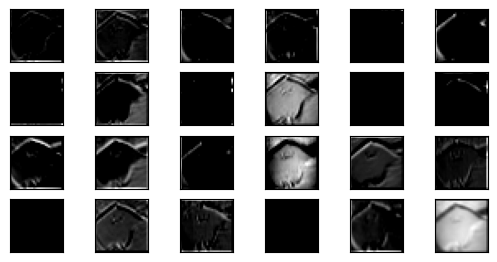

1/1 [==============================] - 0s 36ms/step


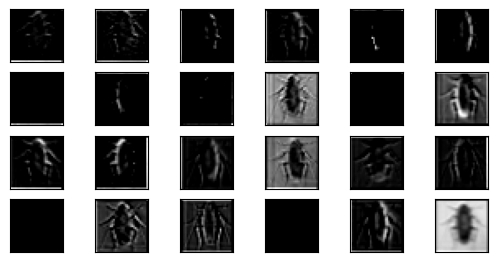

In [49]:
# redefine model to output right after the first hidden layer
modelf = Model(inputs=model.inputs, outputs=model.layers[0].output)
# get feature map for first hidden layer
for i in range(5):
  j=np.random.randint(0, 10000)
  feature_maps = modelf.predict(x_test[j][None,:])
  # plot all 64 maps in an 8x8 squares
  square = 6
  ix = 1
  for _ in range(square - 2):
    for _ in range(square):
      # specify subplot and turn of axis
      ax = plt.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
      ix += 1
  # show the figure
  plt.show()

## Feature Maps of the CNN: <a name="GC"></a>

The following 5 graphs show the random image feature maps of the test set in the first layer of the full model.


## Conclusions <a name="M"></a>
[[back to TOC]](#Head)




The results show that the training process shows that accuracy of the model is stuck at aroung 62%, while it may seem that it is low, the number of classes made the process much more dificult, and for this case it is in fact a very average result. The feature maps shows the contours and patterns that the CNN considered most relevant during the search using the first layer filters, it is also important to note that the model predicted many of the wrong "fine" labeled data in the correct "coarse" label, e. g., a tree of a diferent branch or an animal of a different species, as well as showing the boundaries of the shapes and the contrast between the main body and the background more often than not.